# CNN + LSTM + Dense 
Model: Embed mask, Conv1D, LSTM no seq, Dense, Dropout 

Coding len 1000-2000

Cross validation 5 folds 5 epochs, accuracy mean 55.13% +/- 1.88, F1 mean 59.64% +/- 1.65

58 min on CoLab GPU

In [ ]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-18 13:44:47.716361
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [ ]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=62
FILTERSIZE=8
RCELLS=16
EPOCHS=20
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [ ]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [ ]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [ ]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [ ]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [ ]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-18 13:44:48.616668
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-18 13:44:48.649548
Load sequence...
2022-12-18 13:44:58.209448
Num IDs: 13143
Example IDs: [('ENSG00000186827', 'ENST00000379236.4'), ('ENSG00000127054', 'ENST00000620829.4'), ('ENSG00000235098', 'ENST00000520296.5'), ('ENSG00000187730', 'ENST00000638411.1')]
Count 6959 ones out of 13143 labels.
Example labels: [0, 0, 0, 0]
Num counts: 13143
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162,

## Model

In [ ]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    den1_layer = Dense(RCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(rnn1_layer)
    rnn.add(den1_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [ ]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-18 13:44:58.246982
COMPILE
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1997, 4)           1028      
                                                                 
 conv1d_5 (Conv1D)           (None, 1990, 62)          2046      
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               10112     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                   

## Training

In [ ]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-18 13:44:59.072912
2022-12-18 13:44:59.074680
splitting
Fold 1
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10521, 1997) (10521, 1)
Valid sizes (2622, 1997) (2622, 1)
Train set ones/size 5609 / 10521
Valid set ones/size 1350 / 2622
BUILD MODEL
COMPILE
FIT
2022-12-18 13:45:01.046861
Epoch 1/20
329/329 [==============================] - 79s 106ms/step - loss: 0.6880 - accuracy: 0.5391 - val_loss: 0.6973 - val_accuracy: 0.5359
Epoch 2/20
329/329 [==============================] - 34s 104ms/step - loss: 0.6777 - accuracy: 0.5724 - val_loss: 0.6852 - val_accuracy: 0.5660
Epoch 3/20
329/329 [==============================] - 34s 105ms/step - loss: 0.6683 - accuracy: 0.5946 - val_loss: 0.6869 - val_accuracy: 0.5618
Epoch 4/20
329/329 [==============================] - 34s 103ms/step - loss: 0.6624 - accuracy: 0.6074 - val_loss: 0.6905 - val_accuracy: 0.5576
Epoch 5/20
329/329 [==============================] - 34s 102ms/step - loss: 0.6534 - accuracy: 0.6209 - val_loss:

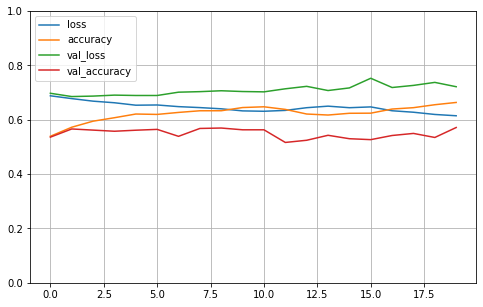

Compute valiation accuracy
2022-12-18 13:57:00.439736
Range of scores: 0.07455954 to 0.9746124
Predicted zeros and ones 1274 1348
Accuracy: 57.13% Precision: 58.38% Recall: 58.30% F1: 58.34%
2022-12-18 13:57:04.604996
Fold 2
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10474, 1997) (10474, 1)
Valid sizes (2669, 1997) (2669, 1)
Train set ones/size 5478 / 10474
Valid set ones/size 1481 / 2669
BUILD MODEL
COMPILE
FIT
2022-12-18 13:57:06.511200
Epoch 1/20
328/328 [==============================] - 37s 105ms/step - loss: 0.6917 - accuracy: 0.5236 - val_loss: 0.6805 - val_accuracy: 0.5661
Epoch 2/20
328/328 [==============================] - 34s 103ms/step - loss: 0.6783 - accuracy: 0.5751 - val_loss: 0.6797 - val_accuracy: 0.5673
Epoch 3/20
328/328 [==============================] - 34s 103ms/step - loss: 0.6750 - accuracy: 0.5854 - val_loss: 0.6889 - val_accuracy: 0.5455
Epoch 4/20
328/328 [==============================] - 34s 103ms/step - loss: 0.6696 - accuracy: 0.5946 - 

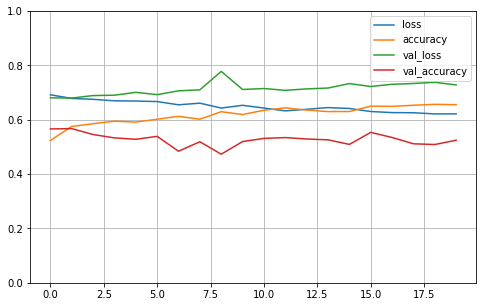

Compute valiation accuracy
2022-12-18 14:08:17.858379
Range of scores: 0.094093636 to 0.83438414
Predicted zeros and ones 1157 1512
Accuracy: 52.45% Precision: 57.01% Recall: 58.20% F1: 57.60%
2022-12-18 14:08:22.076791
Fold 3
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10563, 1997) (10563, 1)
Valid sizes (2580, 1997) (2580, 1)
Train set ones/size 5669 / 10563
Valid set ones/size 1290 / 2580
BUILD MODEL
COMPILE
FIT
2022-12-18 14:08:24.006515
Epoch 1/20
331/331 [==============================] - 38s 104ms/step - loss: 0.6888 - accuracy: 0.5397 - val_loss: 0.6840 - val_accuracy: 0.5624
Epoch 2/20
331/331 [==============================] - 33s 101ms/step - loss: 0.6765 - accuracy: 0.5787 - val_loss: 0.6963 - val_accuracy: 0.5302
Epoch 3/20
331/331 [==============================] - 34s 102ms/step - loss: 0.6740 - accuracy: 0.5889 - val_loss: 0.6939 - val_accuracy: 0.5202
Epoch 4/20
331/331 [==============================] - 34s 101ms/step - loss: 0.6762 - accuracy: 0.5746 

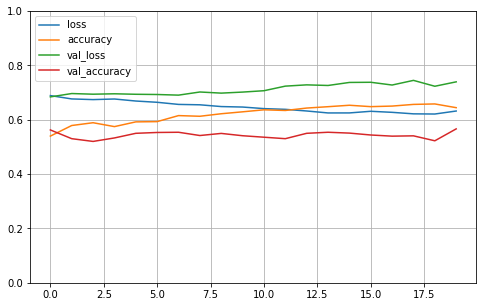

Compute valiation accuracy
2022-12-18 14:19:39.168468
Range of scores: 0.13004844 to 0.94638234
Predicted zeros and ones 1123 1457
Accuracy: 56.63% Precision: 55.87% Recall: 63.10% F1: 59.26%
2022-12-18 14:19:44.934566
Fold 4
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10478, 1997) (10478, 1)
Valid sizes (2665, 1997) (2665, 1)
Train set ones/size 5589 / 10478
Valid set ones/size 1370 / 2665
BUILD MODEL
COMPILE
FIT
2022-12-18 14:19:46.832884
Epoch 1/20
328/328 [==============================] - 37s 104ms/step - loss: 0.6892 - accuracy: 0.5340 - val_loss: 0.6865 - val_accuracy: 0.5546
Epoch 2/20
328/328 [==============================] - 33s 102ms/step - loss: 0.6761 - accuracy: 0.5826 - val_loss: 0.6748 - val_accuracy: 0.5805
Epoch 3/20
328/328 [==============================] - 34s 103ms/step - loss: 0.6799 - accuracy: 0.5689 - val_loss: 0.6892 - val_accuracy: 0.5655
Epoch 4/20
328/328 [==============================] - 34s 102ms/step - loss: 0.6772 - accuracy: 0.5714 -

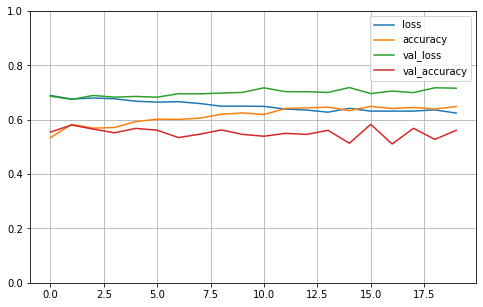

Compute valiation accuracy
2022-12-18 14:31:02.913063
Range of scores: 0.17828807 to 0.91916996
Predicted zeros and ones 947 1718
Accuracy: 56.10% Precision: 55.82% Recall: 70.00% F1: 62.11%
2022-12-18 14:31:09.272680
Fold 5
Training example
[169 161 129 ...   0   0   0]
Train sizes (10536, 1997) (10536, 1)
Valid sizes (2607, 1997) (2607, 1)
Train set ones/size 5491 / 10536
Valid set ones/size 1468 / 2607
BUILD MODEL
COMPILE
FIT
2022-12-18 14:31:11.194994
Epoch 1/20
330/330 [==============================] - 38s 105ms/step - loss: 0.6921 - accuracy: 0.5155 - val_loss: 0.6778 - val_accuracy: 0.5769
Epoch 2/20
330/330 [==============================] - 34s 103ms/step - loss: 0.6850 - accuracy: 0.5567 - val_loss: 0.6855 - val_accuracy: 0.5489
Epoch 3/20
330/330 [==============================] - 34s 103ms/step - loss: 0.6765 - accuracy: 0.5782 - val_loss: 0.6924 - val_accuracy: 0.5370
Epoch 4/20
330/330 [==============================] - 34s 103ms/step - loss: 0.6686 - accuracy: 0.5909 - 

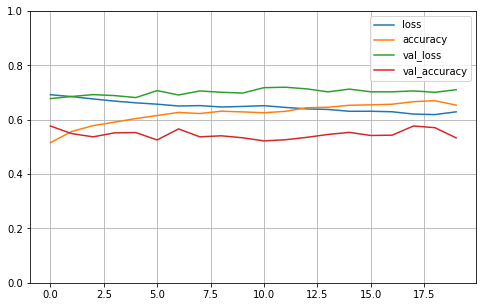

Compute valiation accuracy
2022-12-18 14:42:36.574608
Range of scores: 0.20457198 to 0.8488327
Predicted zeros and ones 964 1643
Accuracy: 53.32% Precision: 57.64% Recall: 64.51% F1: 60.88%
2022-12-18 14:42:40.816039

Cross validation 5 folds 20 epochs
 accuracy mean 55.13% +/- 1.88
 precision mean 56.94% +/- 1.00
 recall mean 62.82% +/- 4.39
 F1 mean 59.64% +/- 1.65
2022-12-18 14:42:40.817877


In [ ]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())